### Gated Hidden State

Alternative to Gradient clipping

The key distinction between vanilla RNNs and GRUs is that the latter support gating of the hidden state. This means that we have dedicated mechanisms for when a hidden state should be updated and also when it should be reset.

#### Recap:

### Neural Networks without Hidden States

$\mathbf{H} = \phi(\mathbf{X} \mathbf{W}_{xh} + \mathbf{b}_h)$

$\mathbf{O} = \mathbf{H} \mathbf{W}_{hq} + \mathbf{b}_q$

### Recurrent Neural Networks with Hidden States

<img src="https://classic.d2l.ai/_images/rnn.svg" />

$\mathbf{H}_t = \phi(\mathbf{X}_t \mathbf{W}_{xh} + \mathbf{H}_{t-1} \mathbf{W}_{hh}  + \mathbf{b}_h)$

$\mathbf{O}_t = \mathbf{H}_t \mathbf{W}_{hq} + \mathbf{b}_q$



#### Reset Gate and Update Gate

<img src="https://classic.d2l.ai/_images/gru-1.svg" />

$\begin{split}\begin{aligned}
\mathbf{R}_t = \sigma(\mathbf{X}_t \mathbf{W}_{xr} + \mathbf{H}_{t-1} \mathbf{W}_{hr} + \mathbf{b}_r)\\
\mathbf{Z}_t = \sigma(\mathbf{X}_t \mathbf{W}_{xz} + \mathbf{H}_{t-1} \mathbf{W}_{hz} + \mathbf{b}_z)
\end{aligned}\end{split}$

#### Candidate Hidden State

<img src="https://classic.d2l.ai/_images/gru-2.svg" />

$\tilde{\mathbf{H}}_t = \tanh(\mathbf{X}_t \mathbf{W}_{xh} + \left(\mathbf{R}_t \odot \mathbf{H}_{t-1}\right) \mathbf{W}_{hh} + \mathbf{b}_h)$

#### Hidden State

<img src="https://classic.d2l.ai/_images/gru-3.svg" />

$\mathbf{H}_t = \mathbf{Z}_t \odot \mathbf{H}_{t-1}  + (1 - \mathbf{Z}_t) \odot \tilde{\mathbf{H}}_t$

$\mathbf{O}_t = \mathbf{H}_t \mathbf{W}_{hq} + \mathbf{b}_q$

### Implementation from Scratch

#### Download Template

In [1]:
!wget https://gist.githubusercontent.com/b1nch3f/b702d2ebfd2c751aa21b68c7425e0d4e/raw/c77225291924a8d2c33c210d74f2744210b6b716/d2l.py -O d2l.py

--2022-07-17 05:45:13--  https://gist.githubusercontent.com/b1nch3f/b702d2ebfd2c751aa21b68c7425e0d4e/raw/c77225291924a8d2c33c210d74f2744210b6b716/d2l.py
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 59707 (58K) [text/plain]
Saving to: ‘d2l.py’

d2l.py              100%[===================>]  58.31K  --.-KB/s    in 0.007s  

2022-07-17 05:45:13 (8.66 MB/s) - ‘d2l.py’ saved [59707/59707]



#### Imports

In [2]:
import tensorflow as tf
import d2l

#### Dataset

In [3]:
batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

#### Initializing Model Parameters

In [4]:
def get_params(vocab_size, num_hiddens):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return tf.random.normal(shape=shape,stddev=0.01,mean=0,dtype=tf.float32)

    def three():
        return (tf.Variable(normal((num_inputs, num_hiddens)), dtype=tf.float32),
                tf.Variable(normal((num_hiddens, num_hiddens)), dtype=tf.float32),
                tf.Variable(tf.zeros(num_hiddens), dtype=tf.float32))

    W_xz, W_hz, b_z = three()  # Update gate parameters
    W_xr, W_hr, b_r = three()  # Reset gate parameters
    W_xh, W_hh, b_h = three()  # Candidate hidden state parameters
    # Output layer parameters
    W_hq = tf.Variable(normal((num_hiddens, num_outputs)), dtype=tf.float32)
    b_q = tf.Variable(tf.zeros(num_outputs), dtype=tf.float32)
    params = [W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q]
    return params

#### Defining the Model

In [5]:
def init_gru_state(batch_size, num_hiddens):
    return (tf.zeros((batch_size, num_hiddens)), )

In [6]:
def gru(inputs, state, params):
    W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    for X in inputs:
        X = tf.reshape(X,[-1,W_xh.shape[0]])
        Z = tf.sigmoid(tf.matmul(X, W_xz) + tf.matmul(H, W_hz) + b_z)
        R = tf.sigmoid(tf.matmul(X, W_xr) + tf.matmul(H, W_hr) + b_r)
        H_tilda = tf.tanh(tf.matmul(X, W_xh) + tf.matmul(R * H, W_hh) + b_h)
        H = Z * H + (1 - Z) * H_tilda
        Y = tf.matmul(H, W_hq) + b_q
        outputs.append(Y)
    return tf.concat(outputs, axis=0), (H,)

#### Training and Predicting

perplexity 1.1, 4727.9 tokens/sec on /CPU:0
time travelleryou can show black is white by argument said filby
travelleryou can show black is white by argument said filby


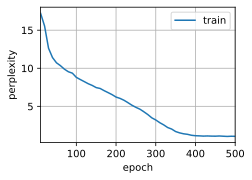

In [7]:
vocab_size, num_hiddens, device_name = len(vocab), 256, d2l.try_gpu()._device_name
# defining tensorflow training strategy
strategy = tf.distribute.OneDeviceStrategy(device_name)
num_epochs, lr = 500, 1
with strategy.scope():
    model = d2l.RNNModelScratch(len(vocab), num_hiddens, init_gru_state, gru, get_params)

d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, strategy)

#### Concise Implementation

perplexity 1.0, 4853.1 tokens/sec on /CPU:0
time traveller with a slight accession ofcheerfulness really thi
travelleryou can show black is white by argument said filby


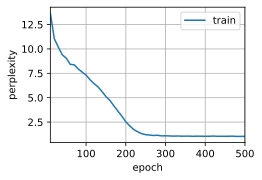

In [8]:
gru_cell = tf.keras.layers.GRUCell(num_hiddens,
    kernel_initializer='glorot_uniform')
gru_layer = tf.keras.layers.RNN(gru_cell, time_major=True,
    return_sequences=True, return_state=True)

device_name = d2l.try_gpu()._device_name
strategy = tf.distribute.OneDeviceStrategy(device_name)
with strategy.scope():
    model = d2l.RNNModel(gru_layer, vocab_size=len(vocab))

d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, strategy)